In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

# Task 1

__1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).__

In [2]:
df = pd.read_csv("/content/owid-covid-data.csv")
df.loc[df["new_cases"] == 0, "new_cases"] = 1

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
TRAIN_SIZE = 50
df["date"] = pd.to_datetime(df["date"])
df_russia = df[(df.location == "Russia") & (df.date >= "2020-03-03")][["total_cases", "new_cases"]].reset_index(drop=True)
df_russia_train, df_russia_test = df_russia[:TRAIN_SIZE], df_russia[TRAIN_SIZE:]

In [5]:
df_russia_test.head(3)

,total_cases,new_cases
50,57999.0,5236.0
51,62773.0,4774.0
52,68622.0,5849.0


# Task 2

__2. Постройте графики целевых переменных. Вы увидите, что число заболевших
растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к
снаряду давайте это и используем.__

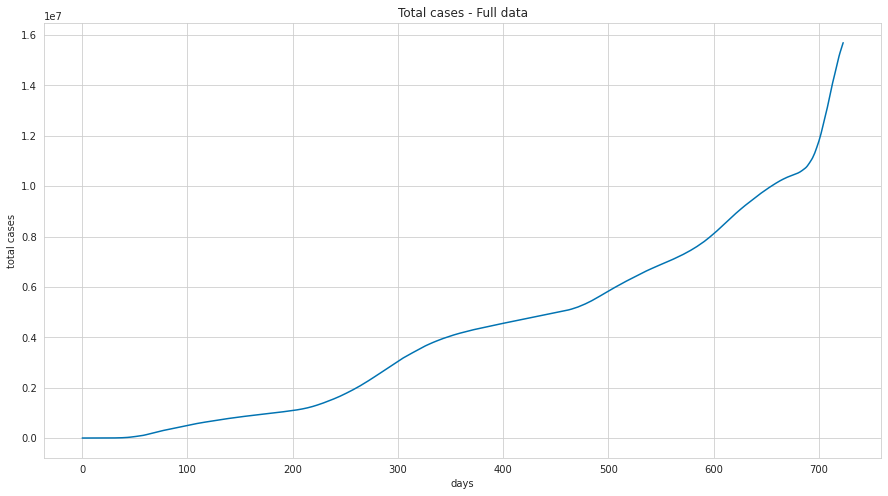

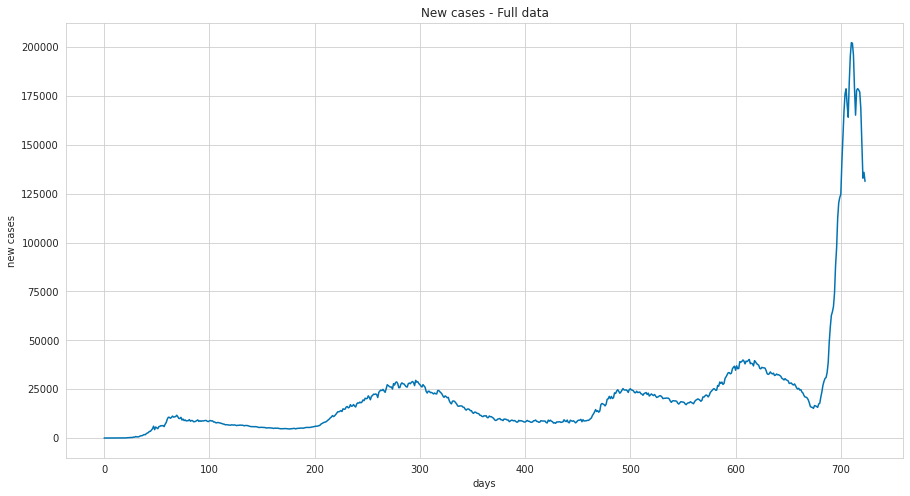

In [6]:
plt.figure(figsize=figsize)
df_russia.total_cases.plot(title="Total cases - Full data")
plt.xlabel("days")
plt.ylabel("total cases")
plt.show()

plt.figure(figsize=figsize)
df_russia.new_cases.plot(title="New cases - Full data")
plt.xlabel("days")
plt.ylabel("new cases")
plt.show()

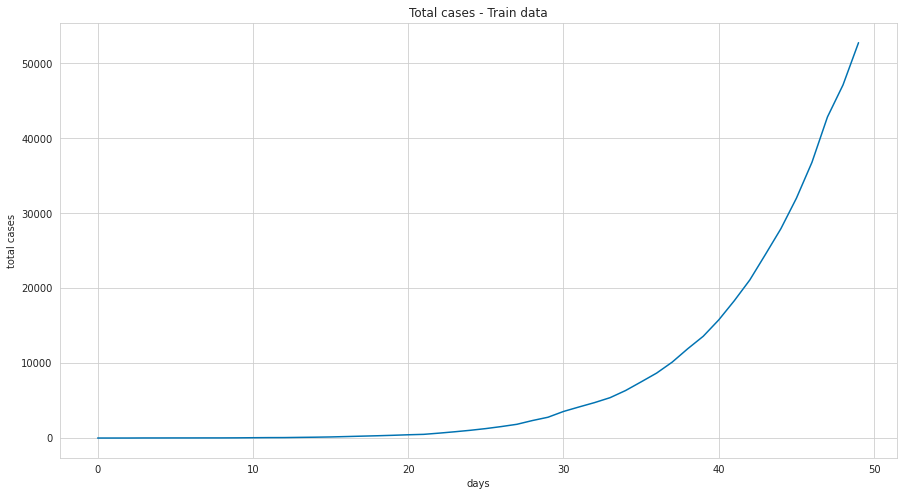

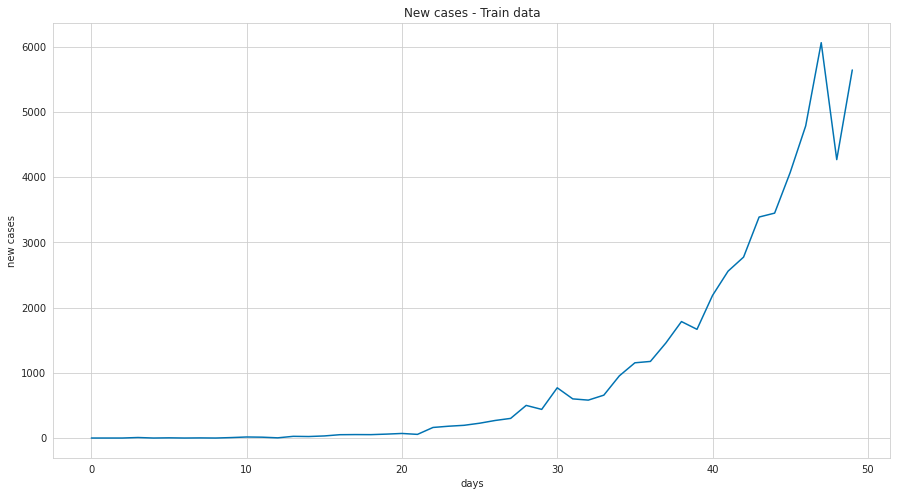

In [7]:
plt.figure(figsize=figsize)
df_russia_train.total_cases.plot(title="Total cases - Train data")
plt.xlabel("days")
plt.ylabel("total cases")
plt.show()

plt.figure(figsize=figsize)
df_russia_train.new_cases.plot(title="New cases - Train data")
plt.xlabel("days")
plt.ylabel("new cases")
plt.show()

## Task 2.a

__2.a. Используя линейную регрессию, обучите модель с экспоненциальным
ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер
текущего дня.__

In [8]:
X = np.array(range(len(df_russia)))

X_train = np.array(range(TRAIN_SIZE))[:, None]
total_cases_train = df_russia_train.total_cases.values
new_cases_train = df_russia_train.new_cases.values
total_cases_log_train = np.log(total_cases_train)
new_cases_log_train = np.log(new_cases_train)

X_test = np.array(range(TRAIN_SIZE, len(df_russia_test) + TRAIN_SIZE))[:, None]
total_cases_test = df_russia_test.total_cases.values
new_cases_test = df_russia_test.new_cases.values
total_cases_log_test = np.log(total_cases_test)
new_cases_log_test = np.log(new_cases_test)

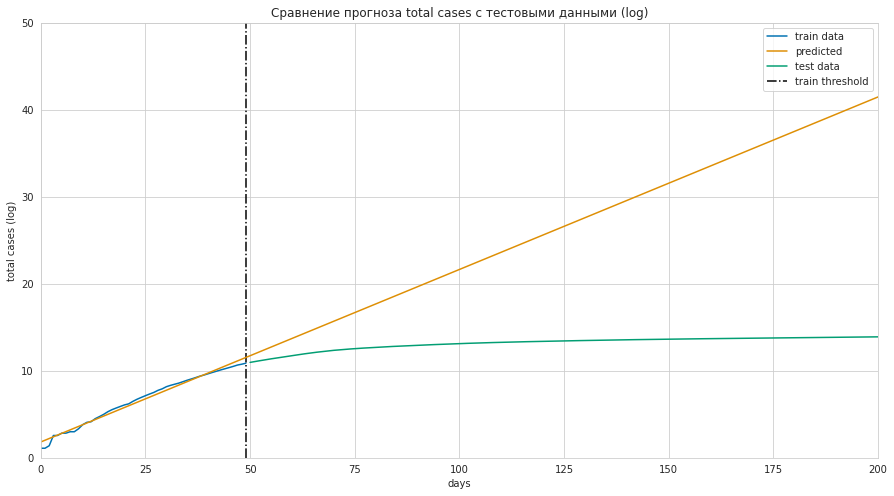

In [9]:
total_cases_lr = LinearRegression()
total_cases_lr.fit(X_train, total_cases_log_train)
total_cases_log_train_preds = total_cases_lr.predict(X_train)
total_cases_log_preds = total_cases_lr.predict(X_test)
total_cases_preds = np.exp(np.append(total_cases_log_train_preds, total_cases_log_preds))

x_max_bound = 200
y_max_bound = 50
plt.figure(figsize=figsize)
plt.title("Сравнение прогноза total cases с тестовыми данными (log)")
plt.plot(X_train, total_cases_log_train, label="train data")
plt.plot(X, np.append(total_cases_log_train_preds, total_cases_log_preds), label="predicted")
plt.plot(X_test, total_cases_log_test, label="test data")
plt.xlim((0, x_max_bound))
plt.ylim((0, y_max_bound))
plt.vlines(TRAIN_SIZE - 1, 0, y_max_bound, linestyles='-.', label="train threshold")
plt.xlabel("days")
plt.ylabel("total cases (log)")
plt.legend()
plt.show()

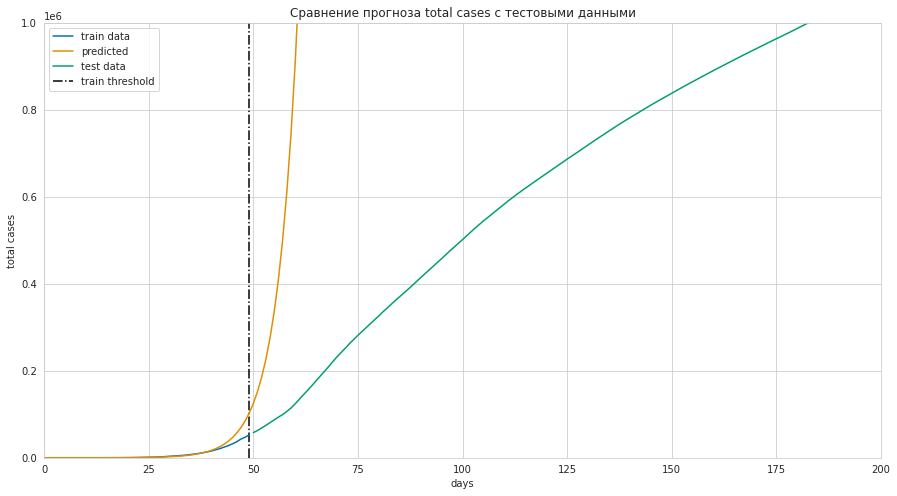

In [10]:
y_max_bound = 1e6
plt.figure(figsize=figsize)
plt.title("Сравнение прогноза total cases с тестовыми данными")
plt.plot(X_train, total_cases_train, label="train data")
plt.plot(X, total_cases_preds, label="predicted")
plt.plot(X_test, total_cases_test, label="test data")
plt.xlim((0, x_max_bound))
plt.ylim((0, y_max_bound))
plt.vlines(TRAIN_SIZE - 1, 0, y_max_bound, linestyles='-.', label="train threshold")
plt.xlabel("days")
plt.ylabel("total cases")
plt.legend()
plt.show()

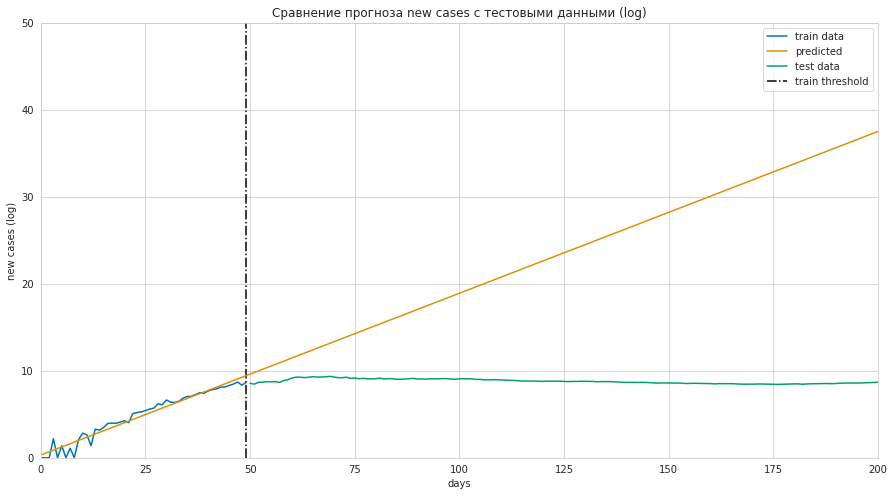

In [11]:
new_cases_lr = LinearRegression()
new_cases_lr.fit(X_train, new_cases_train)

new_cases_lr = LinearRegression()
new_cases_lr.fit(X_train, new_cases_log_train)
new_cases_log_train_preds = new_cases_lr.predict(X_train)
new_cases_log_preds = new_cases_lr.predict(X_test)
new_cases_preds = np.exp(np.append(new_cases_log_train_preds, new_cases_log_preds))

y_max_bound = 50
plt.figure(figsize=figsize)
plt.title("Сравнение прогноза new cases с тестовыми данными (log)")
plt.plot(X_train, new_cases_log_train, label="train data")
plt.plot(X, np.append(new_cases_log_train_preds, new_cases_log_preds), label="predicted")
plt.plot(X_test, new_cases_log_test, label="test data")
plt.xlim((0, x_max_bound))
plt.ylim((0, y_max_bound))
plt.vlines(TRAIN_SIZE - 1, 0, y_max_bound, linestyles='-.', label="train threshold")
plt.xlabel("days")
plt.ylabel("new cases (log)")
plt.legend()
plt.show()

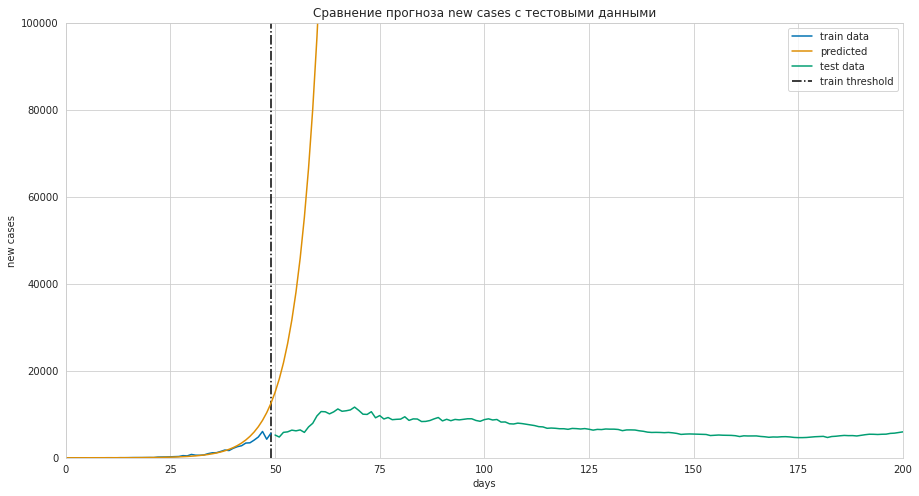

In [12]:
y_max_bound = 1e5
plt.figure(figsize=figsize)
plt.title("Сравнение прогноза new cases с тестовыми данными")
plt.plot(X_train, new_cases_train, label="train data")
plt.plot(X, new_cases_preds, label="predicted")
plt.plot(X_test, new_cases_test, label="test data")
plt.xlim((0, x_max_bound))
plt.ylim((0, y_max_bound))
plt.vlines(TRAIN_SIZE - 1, 0, y_max_bound, linestyles='-.', label="train threshold")
plt.xlabel("days")
plt.ylabel("new cases")
plt.legend()
plt.show()

## Task 2.b

__2.b. Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели (это фактически первый шаг
эмпирического Байеса).__

In [13]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1] + [i for i in x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n


total_cases_log_train_preds = total_cases_lr.predict(X_train)
total_cases_mu = [total_cases_lr.coef_[0], total_cases_lr.intercept_]
total_cases_sigma_noise = (total_cases_log_train - total_cases_log_train_preds).std()

new_cases_log_train_preds = new_cases_lr.predict(X_train)
new_cases_mu = [new_cases_lr.coef_[0], new_cases_lr.intercept_]
new_cases_sigma_noise = (new_cases_log_train - new_cases_log_train_preds).std()

In [14]:
N = 1000

total_cases_cur_mu, total_cases_cur_sigma = np.zeros(2), 5 * np.eye(2)
new_cases_cur_mu, new_cases_cur_sigma = np.zeros(2), 5 * np.eye(2)

X_ = np.linspace(-2, 2.1, N)
Y_ = np.linspace(0.1, 0.3, N)
X_, Y_ = np.meshgrid(X_, Y_)
pos = np.empty(X_.shape + (2,))
pos[:, :, 0] = X_
pos[:, :, 1] = Y_


def myplot_heatmap(Z, true_mu):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.pcolormesh(X_, Y_, Z, cmap=plt.cm.jet)
    plt.scatter(true_mu[0], true_mu[1], marker='*', s=120)
    plt.show()

In [15]:
for i in range(TRAIN_SIZE):
    px, py = X_train[i], total_cases_log_train[i]
    total_cases_cur_mu, total_cases_cur_sigma = bayesian_update(
        mu=total_cases_cur_mu, sigma=total_cases_cur_sigma, 
        x=px, y=py, sigma_noise=total_cases_sigma_noise,
    )
total_cases_Z = multivariate_normal.pdf(pos, mean=total_cases_cur_mu, cov=total_cases_cur_sigma)

for i in range(TRAIN_SIZE):
    px, py = X_train[i], new_cases_log_train[i]
    new_cases_cur_mu, new_cases_cur_sigma = bayesian_update(
        mu=new_cases_cur_mu, sigma=new_cases_cur_sigma, 
        x=px, y=py, sigma_noise=new_cases_sigma_noise
    )
new_cases_Z = multivariate_normal.pdf(pos, mean=new_cases_cur_mu, cov=new_cases_cur_sigma)

w0: 1.8173102531904064
w1: 0.19839463807493174


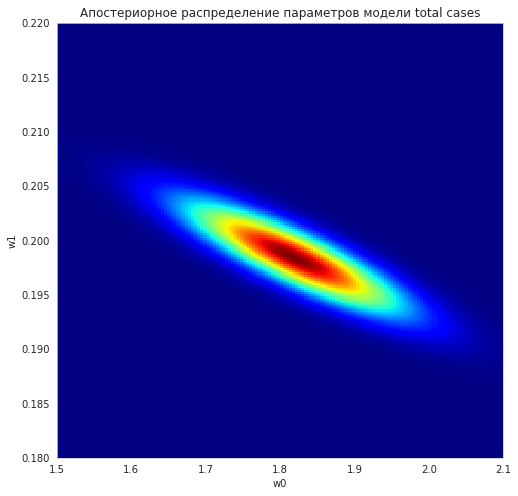

In [16]:
print("w0:", total_cases_cur_mu[0])
print("w1:", total_cases_cur_mu[1])

plt.figure(figsize=(8, 8))
plt.title("Апостериорное распределение параметров модели total cases")
plt.xlabel("w0")
plt.ylabel("w1")
plt.xlim((1.5, 2.1))
plt.ylim((0.18, 0.22))
plt.pcolormesh(X_, Y_, total_cases_Z, cmap=plt.cm.jet)
plt.show()

w0: 0.3189586901358936
w1: 0.18601515344545494


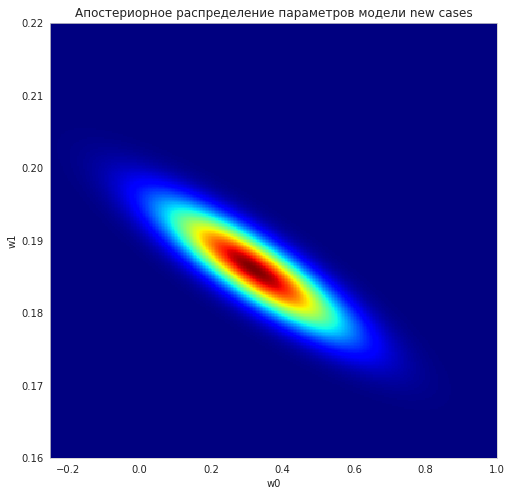

In [17]:
print("w0:", new_cases_cur_mu[0])
print("w1:", new_cases_cur_mu[1])

plt.figure(figsize=(8, 8))
plt.title("Апостериорное распределение параметров модели new cases")
plt.xlabel("w0")
plt.ylabel("w1")
plt.xlim((-0.25, 1.))
plt.ylim((0.16, 0.22))
plt.pcolormesh(X_, Y_, new_cases_Z, cmap=plt.cm.jet)
plt.show()

## Task 2.c

__2.c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя
из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к
1 июня? к 1 сентября? Постройте предсказательные распределения (можно
эмпирически, исходя из данных сэмплирования).__

In [18]:
xs = np.arange(65)

def myplot_sample_lines(mu, sigma, xs, n=20, points=None, title=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
    # plt.ylim((-3, 3))
    # plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

In [19]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1]*xs)
    return res

In [20]:
third_march = pd.to_datetime("2020-03-03")
first_may = pd.to_datetime("2020-05-01")
first_june = pd.to_datetime("2020-06-01")
first_september = pd.to_datetime("2020-09-01")

xs_may = np.arange((first_may - third_march).days)
xs_june = np.arange((first_june - third_march).days)
xs_september = np.arange((first_september - third_march).days)

Прогноз случаев заражения к первому мая в среднем: 616971
Случаев заражения, согласно тестовому набору данных: 114431


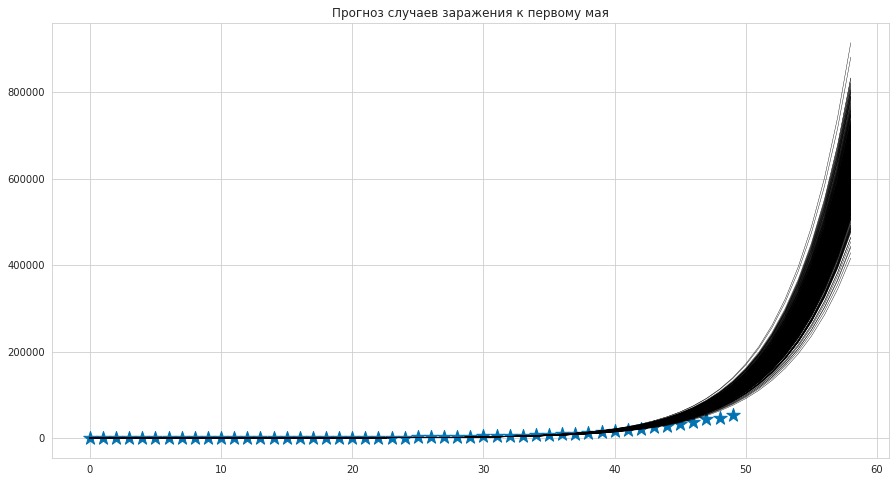

In [21]:
x_may = sample_statistics(total_cases_cur_mu, total_cases_cur_sigma, xs_may, n=500)
print("Прогноз случаев заражения к первому мая в среднем:", int(np.mean(x_may, axis=0)[-1]))
print("Случаев заражения, согласно тестовому набору данных:", int(df_russia_test.loc[(first_may - third_march).days]["total_cases"]))
myplot_sample_lines(total_cases_cur_mu, total_cases_cur_sigma, xs_may, 500, points=[X_train, total_cases_train], title="Прогноз случаев заражения к первому мая")
plt.show()

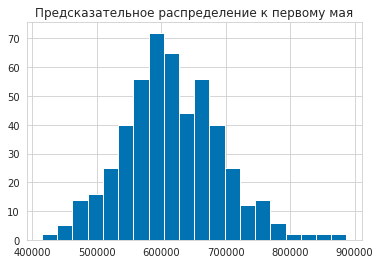

In [22]:
plt.title("Предсказательное распределение к первому мая")
plt.hist(x_may[:, -1], bins=20)
plt.show()

Прогноз случаев заражения к первому июня в среднем: 294682755
Случаев заражения, согласно тестовому набору данных: 414328


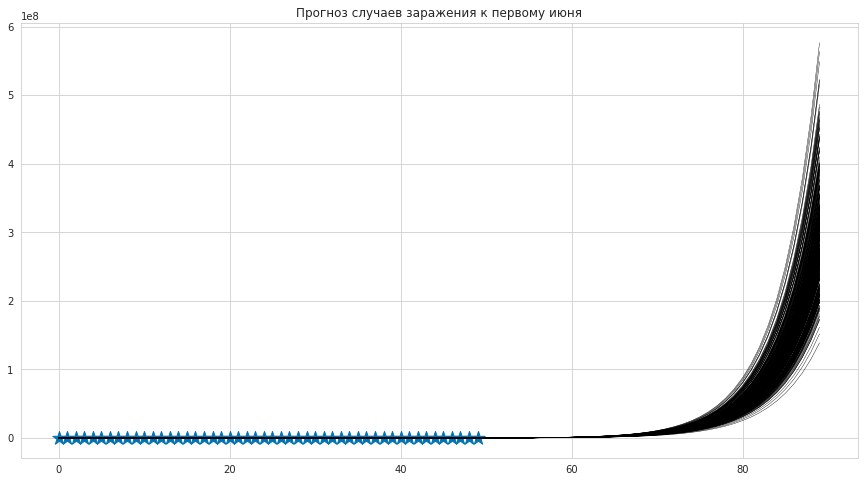

In [23]:
x_june = sample_statistics(total_cases_cur_mu, total_cases_cur_sigma, xs_june, n=500)
print(f"Прогноз случаев заражения к первому июня в среднем: {int(np.mean(x_june, axis=0)[-1])}")
print("Случаев заражения, согласно тестовому набору данных:", int(df_russia_test.loc[(first_june - third_march).days]["total_cases"]))
myplot_sample_lines(total_cases_cur_mu, total_cases_cur_sigma, xs_june, 500, points=[X_train, total_cases_train], title="Прогноз случаев заражения к первому июня")
plt.show()

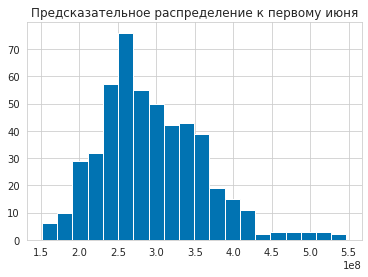

In [24]:
plt.title("Предсказательное распределение к первому июня")
plt.hist(x_june[:, -1], bins=20)
plt.show()

Прогноз случаев заражения к первому сентября в среднем: 29461495983183688
Случаев заражения, согласно тестовому набору данных: 997072


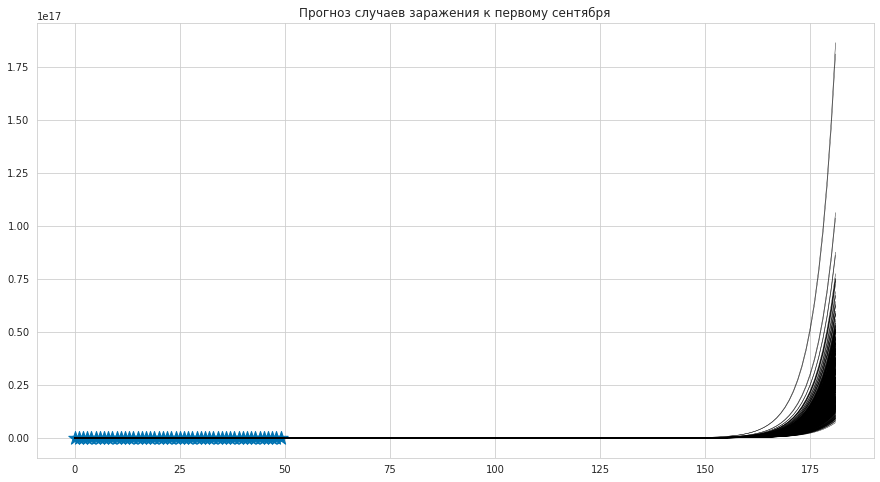

In [25]:
x_september = sample_statistics(total_cases_cur_mu, total_cases_cur_sigma, xs_september, n=500)
print(f"Прогноз случаев заражения к первому сентября в среднем: {int(np.mean(x_september, axis=0)[-1])}")
print("Случаев заражения, согласно тестовому набору данных:", int(df_russia_test.loc[(first_september - third_march).days]["total_cases"]))
myplot_sample_lines(total_cases_cur_mu, total_cases_cur_sigma, xs_september, 500, points=[X_train, total_cases_train], title="Прогноз случаев заражения к первому сентября")
plt.show()

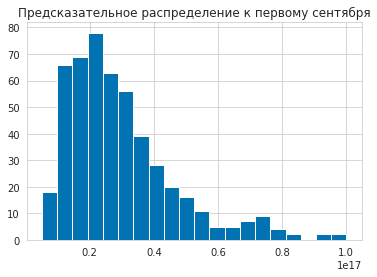

In [26]:
plt.title("Предсказательное распределение к первому сентября")
plt.hist(x_september[:, -1], bins=20)
plt.show()

# Task 3

__Предсказания экспоненциальной модели наверняка получились грустными. Но это,
конечно, чересчур пессимистично — экспоненциальный рост в природе никак не
может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в
реальности имеет сигмоидальный вид: после начальной фазы экспоненциального
роста неизбежно происходит насыщение. В качестве конкретной формы такой
сигмоиды давайте возьмём форму функции распределения для гауссиана.
$$
\Phi(x) = {\frac {1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-t^2/2}dt}
$$
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа
перед интегралом может быть произвольной (и её можно внести в экспоненту), а в
экспоненте под интегралом может быть произвольная квадратичная функция от t.__

## Task 3.a

__3.a. Предложите способ обучать параметры такой сигмоидальной функции при
помощи линейной регрессии.__

__Возьмем дифференциал по х от обеих частей:
$$
\frac {d(\Phi(x))}{dx} = \frac {d(\frac {1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-t^2/2}dt)}{dx} = \frac {1}{\sqrt{2\pi}} e^{ax^2 + bx + c}
$$
Возьмем логарифм от обеих частей получившегося выражения:
$$
ln(\frac {d(\Phi(x))}{dx}) = ln(1) - ln(\sqrt{2\pi}) + ax^2 + bx + c = a_2x^2 + b_2x + c_2
$$
Таким образом, можем суммировать прогнозы для новых случаев (new cases) с целью определения общего числа заболевших (total cases)__

## Task 3.b

__3.b. Обучите эти параметры на датасете случаев коронавируса в России.
Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели.__

In [27]:
new_cases_lr_2 = LinearRegression()
new_cases_lr_2.fit(np.append(X_train, X_train ** 2, axis=1), new_cases_log_train)
new_cases_log_train_preds_2 = new_cases_lr_2.predict(np.append(X_train, X_train ** 2, axis=1))
new_cases_log_preds_2 = new_cases_lr_2.predict(np.append(X_test, X_test ** 2, axis=1))
new_cases_train_preds_2 = np.exp(new_cases_log_train_preds_2)
new_cases_preds_2 = np.exp(new_cases_log_preds_2)

total_cases_log_preds_2 = np.cumsum(np.append(new_cases_log_train_preds_2, new_cases_log_preds_2))
total_cases_preds_2 = np.cumsum(np.append(new_cases_train_preds_2, new_cases_preds_2))

In [28]:
new_cases_mu_2 = [new_cases_lr_2.intercept_, *new_cases_lr_2.coef_]
new_cases_sigma_noise_2 = (new_cases_log_train - new_cases_log_train_preds_2).std()

print("Параметры модели:")
print(new_cases_mu_2[0])
print(new_cases_mu_2[1])
print(new_cases_mu_2[2])

Параметры модели:
-0.3965904028416256
0.27562283190276415
-0.0018297906166869166


In [29]:
new_cases_cur_mu_2, new_cases_cur_sigma_2 = np.zeros(3), 5 * np.eye(3)

for i in range(TRAIN_SIZE):
    px, py = X_train[i], new_cases_log_train[i]
    new_cases_cur_mu_2, new_cases_cur_sigma_2 = bayesian_update(
        mu=new_cases_cur_mu_2, sigma=new_cases_cur_sigma_2, 
        x=[px[0], px[0] ** 2], y=py, sigma_noise=new_cases_sigma_noise_2
    )
    
print(*new_cases_cur_mu_2)

-0.3932826247381769 0.2753503630095828 -0.0018251596467336595


Итоговая модель имеет вид:
$$
f(x) = -0.002x^2 + 0.27x + -0.39
$$

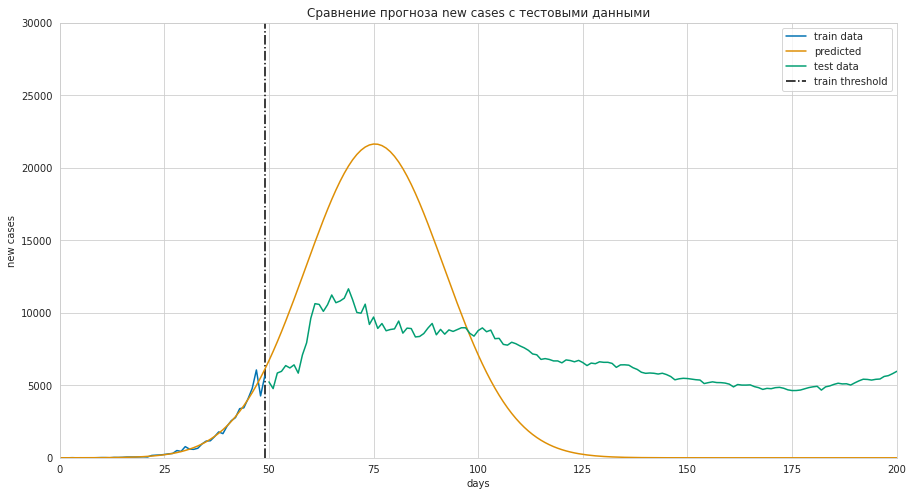

In [30]:
x_max_bound = 200
y_max_bound = 0.3e5
y_min_bound = 0
plt.figure(figsize=figsize)
plt.title("Сравнение прогноза new cases с тестовыми данными")
plt.plot(X_train, new_cases_train, label="train data")
plt.plot(X, np.append(new_cases_train_preds_2, new_cases_preds_2), label="predicted")
plt.plot(X_test, new_cases_test, label="test data")
plt.xlim((0, x_max_bound))
plt.ylim((y_min_bound, y_max_bound))
plt.vlines(TRAIN_SIZE - 1, y_min_bound, y_max_bound, linestyles='-.', label="train threshold")
plt.xlabel("days")
plt.ylabel("new cases")
plt.legend()
plt.show()

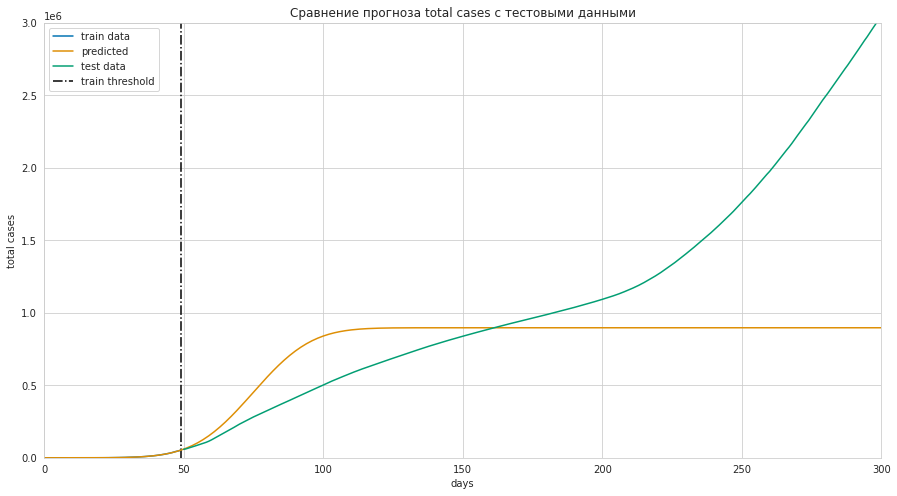

In [31]:
x_max_bound = 300
y_max_bound = 3e6
y_min_bound = 0
plt.figure(figsize=figsize)
plt.title("Сравнение прогноза total cases с тестовыми данными")
plt.plot(X_train, total_cases_train, label="train data")
plt.plot(X, total_cases_preds_2, label="predicted")
plt.plot(X_test, total_cases_test, label="test data")
plt.xlim((0, x_max_bound))
plt.ylim((y_min_bound, y_max_bound))
plt.vlines(TRAIN_SIZE - 1, y_min_bound, y_max_bound, linestyles='-.', label="train threshold")
plt.xlabel("days")
plt.ylabel("total cases")
plt.legend()
plt.show()

## Task 3.c

__3.c. Посэмплируйте много разных сигмоид из апостериорного распределения,
постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев
коронавируса в России? Постройте эмпирическое предсказательное
распределение, нарисуйте графики. Каков ваш прогноз числа случаев
коронавируса в пессимистичном сценарии (90-й процентиль в выборке
числа случаев)? В оптимистичном сценарии (10-й процентиль)?__

In [32]:
def sample_statistics_2(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))
    return res

def myplot_sample_lines_2(mu, sigma, xs, n=20, points=None, title=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    for w in my_w:
        plt.plot(xs, np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2)), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

Прогноз случаев заражения на текущий момент в среднем: 5919102
Случаев заражения, согласно тестовому набору данных: 15697674


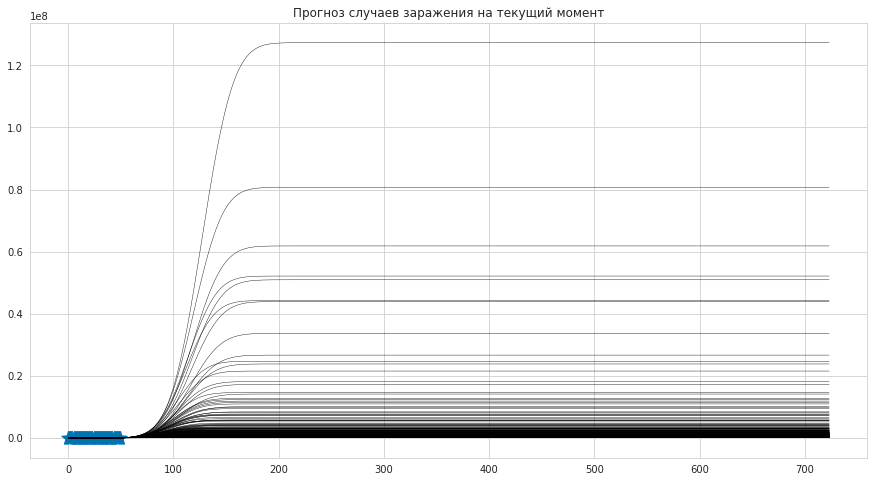

In [33]:
xs = np.arange(len(df_russia))
x = sample_statistics_2(new_cases_cur_mu_2, new_cases_cur_sigma_2, xs, n=300)
print(f"Прогноз случаев заражения на текущий момент в среднем: {int(np.mean(x, axis=0)[-1])}")
print("Случаев заражения, согласно тестовому набору данных:", int(df_russia_test.iloc[-1]["total_cases"]))
myplot_sample_lines_2(new_cases_cur_mu_2, new_cases_cur_sigma_2, xs, 300, points=[X_train, total_cases_train], title="Прогноз случаев заражения на текущий момент")
plt.show()

Прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев): 7322643
Прогноз числа случаев коронавируса в оптимистичном сценарии (10-й процентиль): 310131


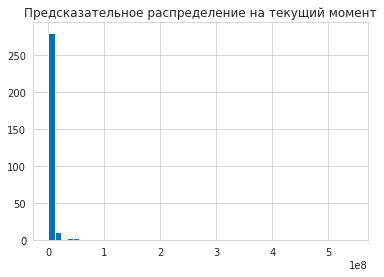

In [34]:
print("Прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев):", int(np.percentile(x[:, -1], 90)))
print("Прогноз числа случаев коронавируса в оптимистичном сценарии (10-й процентиль):", int(np.percentile(x[:, -1], 10)))

plt.title("Предсказательное распределение на текущий момент")
plt.hist(x[:, -1], bins=50)
plt.show()

# Task 4

__Бонус: проведите такой же анализ для других стран (здесь придётся руками
подобрать дни начала моделирования — коронавирус приходил в разные страны в
разное время). Насколько разные параметры получаются? Можно ли разделить
страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?__

# Task 5

__Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам
такого моделирования? Как принять решение, например, о том, нужно ли вводить
карантин?__

Модель с экспоненциальным ростом очень быстро начинает показывать слишком большое число случаев заражения в России. В первые 50 дней хоть и есть признаки экспоненциального роста, но, смотря на тестовые данные, можно заметить, что данные имеют более сложную зависимость. Поэтому данную модель точно не стоит использовать для решения поставленной задачи.  

Предположение о том, что кривая общего числа заболевших имеет сигмоидальный вид, дает более реалистичные результаты, однако, даже в таком случае, прогноз на текущий момент в пессимистичном сценарии _(5 888 939 случаев заражения)_ оказался примерно в 3 раза ниже, чем реальные данные _(15 697 674 случаев заражения)_. Хотя это вполне понятно, ведь при прогнозе на 2022 год мы учитываем только небольшую часть данных 2020 года, из-за чего в определенный момент наступает насыщение, и общее число случаев заражения перестает расти. Стоит учитывать, что со временем менялись различные ограничительные меры, люди стали вакцинироваться, появлялись различные штаммы короновируса, которые имели разную степень заразности, что также влияет на темпы роста случаев заражения.  

Если честно, то трудно сказать, можно ли принимать решения о введении карантина, используя данные подходы. Мне кажется, что нет. На графиках можно заметить, что обычно модель, даже в случае моделирования сигмоидой, сильно завышала число случаев, по сравнению с реальными данными (если смотреть с 50 дня по 100).